In [1]:
import numpy as np
from stable_baselines.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
from utils import plot_returns, targ_circle, Joint2Hand
from imp_cntrl import imp_cntrl
from arm_params import *

import Arm2DEnv as ae


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
# plot episodes returns
log_dir = '../'
plot_returns(log_dir)


In [ ]:
#%% load controler
from stable_baselines import SAC, DDPG
#cntrl = DDPG.load("../best_model.zip")
cntrl = SAC.load("../best_model.zip")

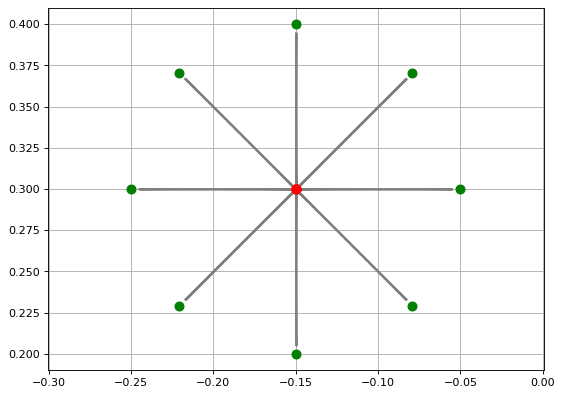

In [8]:
#%% arm dynamics and reward function - Path
t = 0.9 # second
tstep = round(t/dt)
targ_r = 0.1
Theta = [k*np.pi/4 for k in range(8)]

plt.figure(figsize=(8, 6), dpi=80)
for targ_theta in Theta:
    env = ae.ArmModel()
    env.FF = 0
    env.Rot = 0
    env.mode = 'eval'
    targ_loc_rel = targ_circle(targ_r, targ_theta)
    env.set_target(env.wsapce_center + targ_loc_rel)
    env.set_origin(env.wsapce_center)
    x0 = env.reset()
    x = np.copy(x0)
    X = []
    C = []
    for step in range(tstep):
        u = imp_cntrl(step*dt, x, t, env) #cntrl.predict(x)[0] #
        x_next,c,done,info = env.step(u)
        X.append(x)
        C.append(c)

        if done:
            break
        else:
            x = np.copy(x_next)

    #%% plot trajectory
    hand = np.apply_along_axis(Joint2Hand, 1, np.array(X), 'lower','pos', 'vel')

    plt.plot(hand[:,0], hand[:,1], marker='.', markersize=1, color="grey")
    plt.plot(env.origin_hand[0], env.origin_hand[1], marker='o', markersize=8, color="red")
    plt.plot(env.target_hand[0], env.target_hand[1], marker='o', markersize=8, color="green")

plt.axis('equal')
plt.grid()
plt.show()

In [ ]:
#%% arm dynamics and reward function - Speed
t = 0.9 # second
tstep = round(t/dt)
targ_r = 0.1
Theta = [k*np.pi/4 for k in range(8)]

plt.figure(figsize=(8, 6), dpi=80)
for targ_theta in Theta:
    env = ae.ArmModel()
    env.FF = 0
    env.mode = 'eval'
    targ_loc_rel = targ_circle(targ_r, targ_theta)
    env.set_target(env.wsapce_center + targ_loc_rel)
    env.set_origin(env.wsapce_center)
    x0 = env.reset()
    x = np.copy(x0)
    X = []
    C = []
    for step in range(tstep):
        u = cntrl.predict(x)[0] #imp_cntrl(step*dt, x, t, env) #
        x_next,c,done,info = env.step(u)
        X.append(x)
        C.append(c)

        if done:
            break
        else:
            x = np.copy(x_next)

    #%% plot speed
    idx_max = 400
    hand = np.apply_along_axis(Joint2Hand, 1, np.array(X), 'lower','pos', 'vel')
    speed = np.sqrt(hand[:idx_max,2]**2+hand[:idx_max,3]**2)
    plt.plot(speed, color='grey')

plt.xlabel('timestep')
plt.ylabel('Speed (m/s)')
plt.grid()
plt.show()

In [ ]:
#%% arm dynamics and reward function - noising the target
t = 0.9 # second
tstep = round(t/dt)
targ_r = 0.1
Theta = [k*np.pi/4 for k in range(8)]
noise_iter = 20
noise_d = 0.005

plt.figure(figsize=(8, 6), dpi=80)
for targ_theta in Theta:
    for idx in range(noise_iter):
        env = ae.ArmModel()
        targ_loc_rel = targ_circle(targ_r, targ_theta)
        targ_loc_rel_nois = np.array([np.random.uniform(-noise_d, noise_d), np.random.uniform(-noise_d, noise_d)]) # sample noise uniformly in a 5 mm distance
        x0 = env.reset()
        env.set_target(env.wsapce_center + targ_loc_rel + targ_loc_rel_nois)
        x = np.copy(x0)
        X = []
        C = []
        for step in range(tstep):
            u = cntrl.predict(x)[0] #imp_cntrl(step*dt, x, t, env) #
            x_next,c,done,info = env.step(u)
            X.append(x)
            C.append(c)

            if done:
                break
            else:
                x = np.copy(x_next)
        hand = np.apply_along_axis(Joint2Hand, 1, np.array(X), 'lower','pos', 'vel')

        plt.plot(hand[:,0], hand[:,1], marker='.', markersize=1, color="grey")
        plt.plot(env.origin_hand[0], env.origin_hand[1], marker='o', markersize=8, color="red")
        plt.plot(env.target_hand[0], env.target_hand[1], marker='o', markersize=8, color="green")

plt.axis('equal')
plt.grid()
plt.show()